# Seismic Refraction

### Introduction

Code for inverting P-wave traveltime data for up to a three layer problem. Reversed seismic refraction data is required and the method solves for dipping layers.

To use this notebook you will need to enter your data from the field experiments, and perform trial inversions examining the sensitivity of solutions to the data, review the data picks, and develop an integrated P-wave velocity model of the ground water table at the SNARL site.

You should only change the values of the arrays x, t1, t2, w1, and w2 in the box following the label "Enter Data Here"

In [1]:
#Initial Setup and Subroutine Definitions  DO NOT EDIT
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
def seisrefract(x,t,fr,w,c):
    '''
    Program to compute model velocities from array geometry traveltime picks. DO NOT EDIT
    
    Inputs:
      x  : distance vector in feet [np.array]
      t  : measured arrival time picks in seconds [np.array]
      fr : 1=forward; 2=reverse designation of line [int]
      w  : velocity model layer designation [np.array] 
                1 = velocity1 in the velocity model, 2 = velocity2, etc.
                0 = not used
      c  : color of line to plot [str]
      
    Outputs:
      t01, p1, tt1
      
    '''
    
    # set some initial startup variables
    numline=max(w);
    zero=np.where(w==0)[0];
    zflag=len(zero);
    t01=[];
    p1 =[];
    predtime=np.zeros(np.size(w))

    # for-loop over each velocity in the model
    for J in np.arange(1,numline+1,1):
        
        # Find Values to use in regressions
        k=np.where(w==J)[0];
        tmp=np.ones(np.size(k));
        #tmp=np.ones(k);
        X=np.column_stack([tmp.T, x[k].T]);

        # Least-squares solution because matrix is non-square
        a=np.linalg.lstsq(X, t[k].T)[0]
        t01.append(a[0])
        p1.append(a[1])
        tt1=a[0]+a[1]*x;
        linex1=x[k];
        linet1=tt1[k];
        predtime[k]=tt1[k]

        # Plotting
        if fr == 1:
            plt.plot(linex1,linet1,'-',color=c)
            plt.plot(x,t,'o',color=c,markerfacecolor='w',markersize=10)
        elif fr == 2:
            plt.plot(max(x)-linex1,linet1,'-',color=c)
            plt.plot(abs(x-max(x)),t,'o',color=c,markerfacecolor='w',markersize=10)
    
    #  X-out the measurements not assigned to a velocity model (and not used in the inversion)
    if(zflag > 0):
        if fr ==1:
            plt.plot(x[zero],t[zero],marker='+',lw=0,color='k')
        elif fr ==2:
            plt.plot(abs(x[zero]-max(x)),t[zero],marker='+',lw=0,color='k')
            
    # Add labels
    plt.title('Traveltime Plot',fontsize=20)
    plt.xlabel('Distance (ft)',fontsize=18)
    plt.ylabel('Time (sec)',fontsize=18)
    plt.tight_layout()
    plt.savefig("traveltime.png")
    
    return t01,p1,tt1, predtime, zero

## Enter Data in Following Box

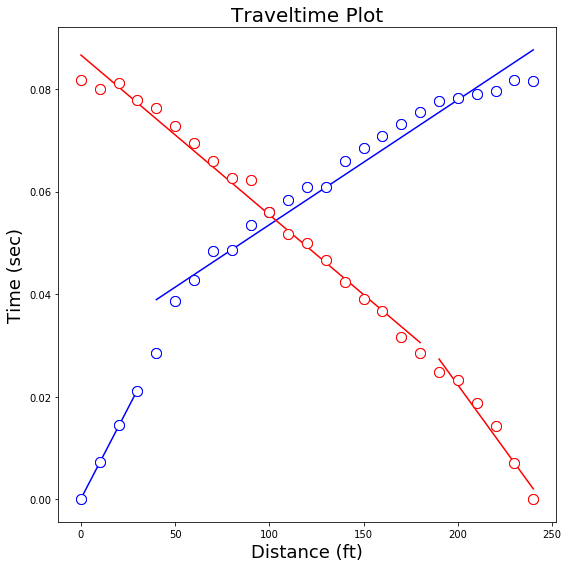

In [3]:
#Enter the Distance Vector (ft)
x= np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240])

#Enter the Measured Arrival Times for forward line (milliseconds) 
t1=np.array([0, 7.3, 14.4, 21.2, 28.6, 38.7, 42.8, 48.51, 48.57, 53.5, 56.1, 58.3, 60.93, 60.96, 65.9, 68.5, 70.8, 73.2, 75.6, 77.7, 78.2, 79.1, 79.7, 81.8, 81.5])
#Enter the curve designator for forward line
w1=np.array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

#Enter the Measured Arrival Times  for reverse line (milliseconds) 
t2=np.array([0, 7.1, 14.3, 18.7, 23.2, 24.9, 28.6, 31.7, 36.8, 39.1, 42.3, 46.7, 50.0, 51.8, 56.0, 62.3, 62.7, 66.0, 69.5, 72.8, 76.3, 77.8, 81.1, 80.1, 81.7])
#Enter the curve designator for reverse line
w2=np.array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

###Do not edit below this line###
#Entered measurements above should be in units of (milliseconds), but we need sec. Multiply by this factor...
timebase=0.001; 
t1 = timebase*t1
t2 = timebase*t2

#Execute seisRefract for each model layer
plt.figure(figsize=(8,8))
t01,p1,tt1, ttt1, z1 = seisrefract(x,t1,1,w1,'blue')
t02,p2,tt2, ttt2, z2 = seisrefract(x,t2,2,w2,'red')

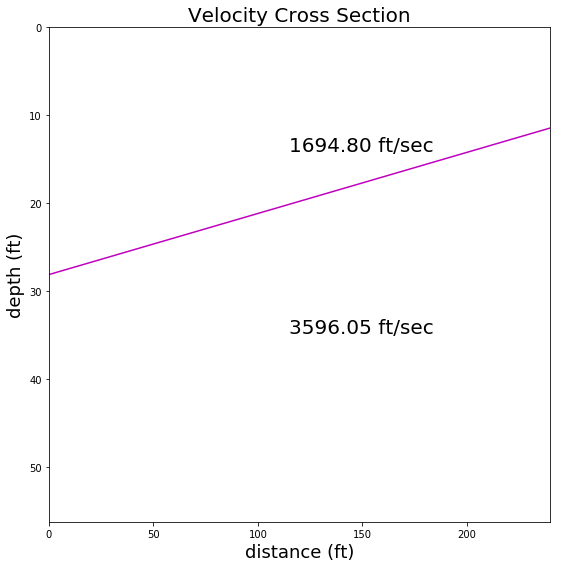

In [4]:
#Interpret and Plot the Results
# Find average upper velocity
numline=np.max(w1)
m=np.size(x)
V0=(1/p1[0] + 1/p2[0])/2;
V0a=1/p1[0];
V0b=1/p2[0];
T0a=t01[0];
T0b=t02[0];
V1a=1/p1[1];
V1b=1/p2[1];
T1a=t01[1];
T1b=t02[1];

i1=0.5*(np.arcsin(V0/V1a)+np.arcsin(V0/V1b));
o1=0.5*(np.arcsin(V0/V1b)-np.arcsin(V0/V1a));

V1=V0/np.sin(i1);

z1a=V0*T1a/(2*np.cos(i1));
z1b=V0*T1b/(2*np.cos(i1));

h1a=z1a/np.cos(o1);
h1b=z1b/np.cos(o1);

#add Next Layer for a 3-layer velocity model
if(numline == 3):

    V2a=1/p1[2];
    V2b=1/p2[2];
    T2a=t01[2];
    T2b=t02[2];

    b21=np.arcsin(V0/V2a)+o1;
    a21=np.arcsin(V0/V2b)-o1;
    g21=np.arcsin(V1/V0*np.sin(a21));
    d21=np.arcsin(V1/V0*np.sin(b21));
    i2=(g21+d21)/2;
    o2=(g21-d21)/2 - o1;
    V2=V1/np.sin(i2);

    z2a=V1*(T2a-z1a/V0*(np.cos(a21+b21)+1)/np.cos(a21))/2/np.cos(i2);
    z2b=V1*(T2b-z1b/V0*(np.cos(a21+b21)+1)/np.cos(b21))/2/np.cos(i2);

    h2a=1/np.cos(o2)*(z1a*np.cos(a21-o2+o1)/np.cos(a21)+z2a);
    h2b=1/np.cos(o2)*(z1b*np.cos(b21+o2-o1)/np.cos(b21)+z2b);
    
fig,ax = plt.subplots(1,1,figsize=(8,8))

# Add labels
plt.title('Velocity Cross Section',fontsize=20)
plt.xlabel('distance (ft)',fontsize=18)
plt.ylabel('depth (ft)',fontsize=18)
plt.tight_layout()

dx = 5
xx=np.arange(x[0], x[len(x)-1]+dx, dx);
yy=np.linspace(h1a, h1b, len(xx));
plt.plot(xx,yy,'m')
ax.text((x[m-1]-x[1])/2,h1a/2,'%.02f ft/sec' % V0,fontsize=20)
ax.text((x[m-1]-x[1])/2,(h1a+h1b)/2+15,'%.02f ft/sec' % V1,fontsize=20)

if(numline == 3):
    yy=np.linspace(h2a, h2b, len(xx));
    plt.plot(xx,yy,'b')
    ax.text((x[m-1]-x[2])/2,(h2a+h2b)/2+15,'%.02f ft/sec' % V2,fontsize=20)

plt.ylim([max(yy)*2,0])
plt.xlim([0,max(x)])
plt.savefig("velocity_section.png")

In [5]:
#Compute Fit Measure, Check for zeroed values and delete
if z1.size:
    t1=np.delete(t1,z1)
    ttt1=np.delete(ttt1,z1)
if z2.size:
    t2=np.delete(t2,z1)
    ttt2=np.delete(ttt2,z1)
    
data=np.append(t1,t2)
pred=np.append(ttt1,ttt2)
fit=np.sqrt(np.mean((data-pred)**2))

#Write results to screen
print('Estimated Velocities and Intercept Times\n')
print('V0a = %.0f  T0a = %f  V0b = %.0f  T0b = %f\n' % (V0a,T0a,V0b,T0b))
print('V1a=%.0f  T1a=%f  V1b=%.0f  T1b=%f\n' % (V1a,T1a,V1b,T1b))
if (numline == 3):
    print('V2a=%.0f  T2a=%f  V2b=%.0f  T2b=%f\n' % (V2a,T2a,V2b,T2b))
print('\n')

print('Goodness of Fit, %f' % (fit))
print('\n')

print('Depth(ft)    Depth(ft)     Velocity(ft/sec)\n')
print('   0            0             %.0f\n' % (V0))
print('  %.1f         %.1f            %.0f\n' % (h1a, h1b, V1))
if(numline == 3):
    print('  %.1f         %.1f          %.0f\n' % (h2a, h2b, V2))

Estimated Velocities and Intercept Times

V0a = 1414  T0a = 0.000120  V0b = 1975  T0b = 0.002043

V1a=4107  T1a=0.029194  V1b=3211  T1b=0.011874



Goodness of Fit, 0.002590


Depth(ft)    Depth(ft)     Velocity(ft/sec)

   0            0             1695

  28.1         11.4            3596

